In [1]:
#Import standard python modules
import os.path
import sys
import xarray as xr
import numpy as np

#Determine local directory path:
local_path = os.path.abspath('') # os.path.dirname(os.path.abspath(__file__))
print(f"Local path appears to be {local_path}")

#set path to ADF lib:
lib_path = os.path.join(local_path,"lib")
print(f"Lib path appears to be {lib_path}")

#set path to ADF plotting scripts directory:
plotting_scripts_path = os.path.join(local_path, "scripts", "plotting")
print(plotting_scripts_path)

#Add paths to python path:
sys.path.append(lib_path)
sys.path.append(plotting_scripts_path)

#Import ADF diagnostics object:
from adf_diag import AdfDiag

Local path appears to be /glade/u/home/brianpm/Code/CAM_diagnostics
Lib path appears to be /glade/u/home/brianpm/Code/CAM_diagnostics/lib
/glade/u/home/brianpm/Code/CAM_diagnostics/scripts/plotting


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
from pathlib import Path
config_file = Path.home()/"drive_diagnostics"/"test_variable_prefs.yaml"

#Set path to config YAML file:
# config_fil = "/Users/brianpm/Code/scratch/CAM_diagnostics/config_user_module_example.yaml"

#Initialize ADF object:
adf = AdfDiag(config_file)

In [4]:
basic_info_dict = adf.read_config_var("diag_basic_info")
print(basic_info_dict)

testcase_dict = adf.read_config_var("diag_cam_climo")
print(testcase_dict)

baseline_dict = adf.read_config_var("diag_cam_baseline_climo")
print(baseline_dict)

{'compare_obs': False, 'create_html': True, 'obs_climo_loc': '/glade/work/brianpm/observations/climo_files', 'cam_regrid_loc': '/glade/scratch/brianpm/cam_diag_regrid_files', 'cam_overwrite_regrid': True, 'cam_diag_plot_loc': '/glade/scratch/brianpm/cam_diag_plots', 'use_defaults': True}
{'cam_case_name': 'b.e20.BHIST.f09_g17.20thC.297_05', 'calc_cam_climo': True, 'cam_overwrite_climo': False, 'cam_hist_loc': '/glade/p/cesm/ADF/b.e20.BHIST.f09_g17.20thC.297_05/', 'start_year': 1990, 'end_year': 1999, 'cam_ts_done': False, 'cam_ts_save': True, 'cam_overwrite_ts': False, 'cam_ts_loc': '/glade/scratch/brianpm/cam_diag_ts_files', 'cam_climo_loc': '/glade/scratch/brianpm/cam_diag_climo/files/b.e20.BHIST.f09_g17.20thC.297_05', 'cam_regrid_loc': '/glade/scratch/brianpm/cam_diag_regrid_files'}
{'calc_cam_climo': True, 'cam_overwrite_climo': True, 'cam_case_name': 'b.e20.BHIST.f09_g16.20thC.125.02', 'cam_hist_loc': '/glade/p/cesm/ADF/b.e20.BHIST.f09_g16.20thC.125.02', 'cam_climo_loc': '/glade/s

In [5]:
## WHERE ARE THE CLIMO FILES:


# reference case:
list(Path(baseline_dict['cam_climo_loc']).glob(baseline_dict['cam_case_name']+"*"))


# test case(s):
list(Path(testcase_dict['cam_climo_loc']).glob(testcase_dict['cam_case_name']+"*"))

[PosixPath('/glade/scratch/brianpm/cam_diag_climo/files/b.e20.BHIST.f09_g17.20thC.297_05/b.e20.BHIST.f09_g17.20thC.297_05_T_climo.nc'),
 PosixPath('/glade/scratch/brianpm/cam_diag_climo/files/b.e20.BHIST.f09_g17.20thC.297_05/b.e20.BHIST.f09_g17.20thC.297_05_PSL_climo.nc'),
 PosixPath('/glade/scratch/brianpm/cam_diag_climo/files/b.e20.BHIST.f09_g17.20thC.297_05/b.e20.BHIST.f09_g17.20thC.297_05_RELHUM_climo.nc'),
 PosixPath('/glade/scratch/brianpm/cam_diag_climo/files/b.e20.BHIST.f09_g17.20thC.297_05/b.e20.BHIST.f09_g17.20thC.297_05_PRECC_climo.nc'),
 PosixPath('/glade/scratch/brianpm/cam_diag_climo/files/b.e20.BHIST.f09_g17.20thC.297_05/b.e20.BHIST.f09_g17.20thC.297_05_LWCF_climo.nc'),
 PosixPath('/glade/scratch/brianpm/cam_diag_climo/files/b.e20.BHIST.f09_g17.20thC.297_05/b.e20.BHIST.f09_g17.20thC.297_05_U_climo.nc'),
 PosixPath('/glade/scratch/brianpm/cam_diag_climo/files/b.e20.BHIST.f09_g17.20thC.297_05/b.e20.BHIST.f09_g17.20thC.297_05_SWCF_climo.nc'),
 PosixPath('/glade/scratch/bria

In [6]:
#Case names:
reference_name = adf.get_baseline_info('cam_case_name', required=True)
case_names = adf.get_cam_info('cam_case_name', required=True)  # Loop over these


In [7]:
case_loc = adf.get_cam_info('cam_climo_loc', required=True)

In [8]:
base_loc = adf.get_baseline_info('cam_climo_loc', required=True)

In [25]:
# --- DERIVED VARIABLES --- 

def _pressure_from_hybrid(psfc, hya, hyb, p0=100000.):
    """Calculate pressure at the hybrid levels."""

    # p(k) = hya(k) * p0 + hyb(k) * psfc

    # This will be in Pa
    return hya * p0 + hyb * psfc


def vertical_average(fld, ps, acoef, bcoef):
    # get pressure field
    pres = _pressure_from_hybrid(ps, acoef, bcoef)
    # get del_pressure
    # return sum(fld * del_pressure) / sum(del_pressure)

    # integral of del_pressure turns out to be just the average of the square of the boundaries:
    # -- assume lev is a coordinate and is nominally in pressure units
    maxlev = pres['lev'].max().item()
    minlev = pres['lev'].min().item()
    dp_integrated = 0.5 * (pres.sel(lev=maxlev)**2 - pres.sel(lev=minlev)**2)

    levaxis = fld.dims.index('lev')  # fld needs to be a dataarray
    assert isinstance(levaxis, int), f'the axis called lev is not an integer: {levaxis}'

    fld_integrated = np.trapz(fld * pres, x=pres, axis=levaxis)
    return fld_integrated / dp_integrated




def find_landmask(adf, casename, location):
    # maybe it's in the climo files, but we might need to look in the history files:
    landfrac_fils = list(Path(location).glob(f"{casename}*_LANDFRAC_*.nc"))
    if landfrac_fils:
        return xr.open_dataset(landfrac_fils[0])['LANDFRAC']
    else:
        if casename in adf.get_cam_info('cam_case_name'):
            hloc = adf.get_cam_info('cam_hist_loc')
        else:
            hloc = adf.get_baseline_info('cam_hist_loc')
        hfils = Path(hloc).glob((f"*{casename}*.nc"))
        if not hfils:
            raise IOError(f"No history files in expected location: {hloc}")
        k = 0
        for h in hfils:
            dstmp = xr.open_dataset(h)
            if 'LANDFRAC' in dstmp:
                print(f"Good news, found LANDFRAC in file: {h}")
                return dstmp['LANDFRAC']
            else:
                k += 1
        else:
            raise IOError(f"Checked {k} files, but did not find LANDFRAC in any of them.")
            return None


def get_prect(casename, location):
    # look for prect first:
    fils = sorted(list(Path(location).glob(f"{casename}*_PRECT_*.nc")))
    if len(fils) == 0:
        print("Need to derive PRECT = PRECC + PRECL")
        fils1 = sorted(list(Path(location).glob(f"{casename}*_PRECC_*.nc")))
        fils2 = sorted(list(Path(location).glob(f"{casename}*_PRECL_*.nc")))
        if (len(fils1) == 0) or (len(fils2) == 0):
            raise IOError("Could not find PRECC or PRECL")
        else:
            if len(fils1) == 1:
                precc = xr.open_dataset(fils1[0])['PRECC']
                precl = xr.open_dataset(fils2[0])['PRECL']
                prect = precc + precl 
            else:
                print("Need to deal with mult-file case.")
    elif len(fils) > 1:
        prect = xr.open_mfdataset(fils)['PRECT'].load()  # do we ever expect climo files split into pieces? 
    else:
        prect = xr.open_dataset(fils[0])['PRECT']
    return prect


def get_tropical_land_precip(adf, casename, location):
    # get landfrac
    landfrac = find_landmask(adf, casename, location)
    if landfrac is None:
        raise ValueError("No landfrac returned")
    # get prect 
    prect = get_prect(casename, location)
    # mask to only keep land locations
    prect = xr.DataArray(np.where(landfrac >= .95, prect, np.nan),
                         dims=prect.dims,
                         coords=prect.coords,
                         attrs=prect.attrs)  # threshold could be 1
    return prect.sel(lat=slice(-30,30))


def get_tropical_ocean_precip(adf, casename, location):
    # get landfrac
    landfrac = find_landmask(adf, casename, location)
    if landfrac is None:
        raise ValueError("No landfrac returned")
    # get prect 
    prect = get_prect(casename, location)
    # mask to only keep ocean locations
    prect = xr.DataArray(np.where(landfrac <= 0, prect, np.nan),
                         dims=prect.dims,
                         coords=prect.coords,
                         attrs=prect.attrs)  
    return prect.sel(lat=slice(-30,30))


def get_u_at_plev(adf, casename, location):
    # parse input to know variable and pressure value
    # get variable
    # TODO: are variables saved on pressure levels, or do we need to interpolate?
    # return variable on plev
    pass

def get_virh(adf, casename, location):
    # get RELHUM climo
    # get PS
    # TODO: on pressure levels already?
    # TODO: RELHUM will have hyam, hybm? 
    # vertical_average(RELHUM, PS)
    pass

def get_vit(adf, casename, location):
    # get T climo
    # get PS
    # TODO: on pressure levels already?
    # TODO: T will have hyam, hybm? 
    # vertical_average(T, PS)
    pass

def get_derive_func(fld):
    funcs = {'TropicalLandPrecip': get_tropical_land_precip,
    'TropicalOceanPrecip': get_tropical_ocean_precip,
    'U300': get_u_at_plev,
    'VIRelativeHumidity': get_virh,
    'VITemperature': get_vit,
    }
    return funcs[fld]

def _retrieve(adfobj, variable, casename, location):
    v_to_derive = ['TropicalLandPrecip', 'TropicalOceanPrecip', 'EquatorialPacificStress', 
                'U300', 'ColumnRelativeHumidity', 'ColumnTemperature']
    if variable not in v_to_derive:
        fils = sorted(list(Path(location).glob(f"{casename}*_{variable}_*.nc")))
        print(fils)
        if len(fils) == 0:
            raise ValueError("something went wrong")
        elif len(fils) > 1:
            ds = xr.open_mfdataset(fils)  # do we ever expect climo files split into pieces? 
        else:
            ds = xr.open_dataset(fils[0])
    else:
        func = get_derive_func(variable)
        print(func)
        ds = func(adfobj, casename, location)
    return ds 


In [9]:
prect = _retrieve(adf, "TropicalOceanPrecip", reference_name, base_loc)

<function get_tropical_ocean_precip at 0x2b76b33aea60>
Good news, found LANDFRAC in file: /glade/p/cesm/ADF/b.e20.BHIST.f09_g16.20thC.125.02/b.e20.BHIST.f09_g16.20thC.125.02.cam.h0.1996-01.nc
Need to derive PRECT = PRECC + PRECL


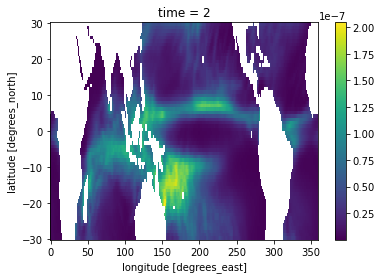

In [10]:
prect.isel(time=1).plot.pcolormesh()

In [11]:
temperature = _retrieve(adf, "T", reference_name, base_loc)

[PosixPath('/glade/scratch/brianpm/cam_diag_climo/files/b.e20.BHIST.f09_g16.20thC.125.02/b.e20.BHIST.f09_g16.20thC.125.02_T_climo.nc')]


In [30]:
temperature

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, lev: 32, time: 12, ilev: 33)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * ilev     (ilev) float64 2.255 5.032 10.16 18.56 ... 947.4 967.5 985.1 1e+03
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    hyam     (time, lev) float64 0.003643 0.007595 0.01436 ... 0.001989 0.0
    hybm     (time, lev) float64 0.0 0.0 0.0 0.0 ... 0.9251 0.9512 0.9743 0.9926
    P0       (time) float64 1e+05 1e+05 1e+05 1e+05 ... 1e+05 1e+05 1e+05 1e+05
    hyai     (time, ilev) float64 0.002255 0.005032 0.01016 ... 0.003979 0.0 0.0
    hybi     (time, ilev) float64 0.0 0.0 0.0 0.0 ... 0.9389 0.9636 0.9851 1.0
    PS       (time, lat, lon) float32 ...
    T        (time, lev, lat, lon) float32 ...

In [27]:
vatemp = vertical_average(temperature['T'], temperature['PS'], temperature['hyam'], temperature['hybm'])

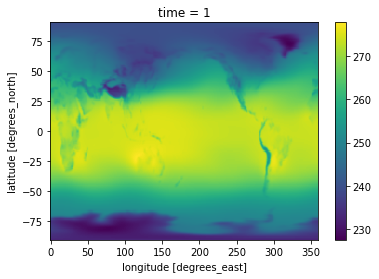

In [29]:
vatemp[0,:,:].plot.pcolormesh()

In [57]:
# adf.ge   'cam_hist_loc'
# dir(adf)
# diag_cam_climo:
  # cam_case_name:
  
  
adf.get_cam_info('cam_case_name')[0] == case_names[0]

True

In [55]:
adf.get_baseline_info('cam_case_name') == case_names[0]

False

In [56]:
adf.get_cam_info('cam_case_name')[0]

'b.e20.BHIST.f09_g17.20thC.297_05'

In [53]:
case_names[0]

'b.e20.BHIST.f09_g17.20thC.297_05'

In [58]:
adf.get_cam_info('cam_hist_loc')

['/glade/p/cesm/ADF/b.e20.BHIST.f09_g17.20thC.297_05/']

In [31]:
uwind = _retrieve(adf, "U", reference_name, base_loc)

[PosixPath('/glade/scratch/brianpm/cam_diag_climo/files/b.e20.BHIST.f09_g16.20thC.125.02/b.e20.BHIST.f09_g16.20thC.125.02_U_climo.nc')]


In [9]:
import geocat.comp as gc

In [35]:
u300 = gc.interp_hybrid_to_pressure(uwind['U'], uwind['PS'], uwind['hyam'], uwind['hybm'], new_levels=np.array([30000.0]), lev_dim='lev')

In [39]:
u300.squeeze(drop=True)

<xarray.DataArray '_vertical_remap-f39258875db323c69f147f83ff86b8c1' (time: 12, lat: 192, lon: 288)>
dask.array<getitem, shape=(12, 192, 288), dtype=float32, chunksize=(12, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [10]:
import pandas as pd

In [41]:
var_list = ['SLP', 'SWCF', 'LWCF', 
                'TropicalLandPrecip', 'TropicalOceanPrecip', 'EquatorialPacificStress', 
                'U300', 'ColumnRelativeHumidity', 'ColumnTemperature']

df_template = pd.DataFrame(index=var_list, columns=['case', 'corr', 'ratio', 'bias'])

In [49]:
df_template

,case,corr,ratio,bias
SLP,NaN,NaN,NaN,NaN
SWCF,NaN,NaN,NaN,NaN
LWCF,NaN,NaN,NaN,NaN
TropicalLandPrecip,NaN,NaN,NaN,NaN
TropicalOceanPrecip,NaN,NaN,NaN,NaN
EquatorialPacificStress,NaN,NaN,NaN,NaN
U300,mycasename,0.001,2.3,400.1
ColumnRelativeHumidity,NaN,NaN,NaN,NaN
ColumnTemperature,NaN,NaN,NaN,NaN


In [46]:
adf.get_cam_info('cam_climo_loc', required=True)

['/glade/scratch/brianpm/cam_diag_climo/files/b.e20.BHIST.f09_g17.20thC.297_05']

In [48]:
df_template.loc['U300'] = ['mycasename', 0.001, 2.3, 400.1]

In [50]:
df_template.loc['SLP'] = ('mycasename2', 0.999, 0.3, 1.1)
df_template

,case,corr,ratio,bias
SLP,mycasename2,0.999,0.3,1.1
SWCF,NaN,NaN,NaN,NaN
LWCF,NaN,NaN,NaN,NaN
TropicalLandPrecip,NaN,NaN,NaN,NaN
TropicalOceanPrecip,NaN,NaN,NaN,NaN
EquatorialPacificStress,NaN,NaN,NaN,NaN
U300,mycasename,0.001,2.3,400.1
ColumnRelativeHumidity,NaN,NaN,NaN,NaN
ColumnTemperature,NaN,NaN,NaN,NaN


In [56]:
# Set up the Taylor Diagram foundation
def taylor_plot_setup():
    """Constructs Figure and Axes objects for basic Taylor Diagram."""
    fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection':'polar'})
    corr_labels = np.array([0.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .99, 1.])
    corr_locations = np.pi/2 - np.arccos((corr_labels))  # azim. ticks in radians.
    ax.set_thetamin(0)
    ax.set_thetamax(90)
    ax.set_ylim([0, 1.6])  # Works better than set_rmin / set_rmax
    ax.set_theta_zero_location("N") # zero at top, 
    ax.set_theta_direction(-1)  # angle increases clockwise
    thetalines, thetalabels = ax.set_thetagrids(np.degrees(corr_locations), corr_labels)
    ax.grid(axis='x', linewidth=0)  # turn off radial grid
    ax.set_rgrids(np.arange(0, 1.75, .25))
    # ax.set_yticks([0.0, 1.0, 1.25]) # same effect as set_rgrids()
    ax.set_ylabel("Standardized Deviations")
    # Add tick marks along azimuth
    tick = [ax.get_rmax(),ax.get_rmax()*0.97]
    for t in corr_locations:
        ax.plot([t,t], tick, lw=0.72, color="k")
    ax.text(np.radians(50), ax.get_rmax()*1.1, "Correlation", ha='center', rotation=-50, fontsize=15)
    ax.text(np.radians(95), 1.0, "REF", ha='center')
    return fig, ax


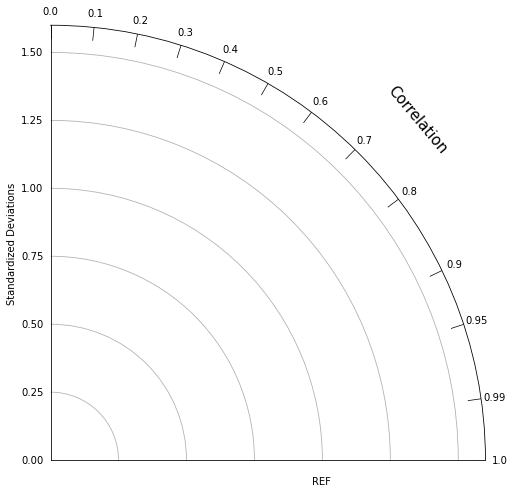

In [57]:
f2, a2 = taylor_plot_setup()

In [60]:
#
# Now we apply data on top of the Axes
#
#     We need at least correlation and the normalized standard deviation. 
#     Optionally we can use the bias. 
#     Given a CASE, expect a DataFrame with columns: variable, correlation, norm. std. dev.[, bias] (where variable is the "index")

def plot_taylor_data(wks, df, **kwargs):
    """Apply data on top of the Taylor Diagram Axes.
    
        wks -> Axes object, probably from taylor_plot_setup

        df  -> DataFrame holding the Taylor stats.

        kwargs -> optional arguments
          look for 'use_bias'
          look for 'case_color'
    
    """
    # option is whether to stylize the markers by the bias:
    use_bias = False
    if 'use_bias' in kwargs:
        if kwargs['use_bias']:
            use_bias = True
            df['bias_digi'] = np.digitize(df['bias'].values, [-20, -10, -5, -1, 1, 5, 10, 20])
            marker_list = ["v", "v", "v", "v", "o", "^", "^", "^", "^"]
            marker_size = [24, 16, 8, 4, 4, 4, 8, 16, 24]

    # option: has color been specified as case_color?
    # --> expect the case labeling to be done external to this function
    if 'case_color' in kwargs:
        color = kwargs['case_color']
        if isinstance(color, int):
            # assume we should use this as an index
            color = mpl.cm.tab20(color) # convert to RGBA 
            # TODO: allow colormap to be specified.
    

    annos = []  # list will hold strings for legend
    k = 1
    for ndx, row in df.iterrows:
        # NOTE: ndx will be the DataFrame index, and we expect that to be the variable name
        theta = np.pi/2 - np.arccos(row['corr'])  # Transform DATA
        if use_bias:
            mk = marker_list[row['bias_digi']]
            mksz = marker_size[row['bias_digi']]
            ax.plot(theta, row['ratio'], marker=mk, markersize=mksz, color=color)
        else:
            wks.plot(theta, row['ratio'], marker='o', markersize=16, color=color)
        annos.append(f"{k} - {ndx.replace('_','')}")
        wks.annotate(str(k), (theta, row['ratio']), ha='center', va='bottom', 
                            xytext=(0,5), textcoords='offset points', fontsize='x-large', color=color)
        k += 1  # increment the annotation number (THIS REQUIRES CASES TO HAVE SAME ORDER IN DataFrame)
    return wks



def taylor_plot_finalize(wks, casenames, casecolors, needs_bias_labels=True):
    """Apply final formatting to a Taylor diagram.
    
        wks -> Axes object that has passed through taylor_plot_setup and plot_taylor_data
        casenames -> list of case names for the legend
        casecolors -> list of colors for the cases
        needs_bias_labels -> Bool, if T make the legend for the bias-sized markers.
    """
textstr = "\n".join(casenames)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
wks.text(0.05, 0.05, textstr, transform=ax.transAxes, fontsize=11, bbox=props)

if needs_bias_labels:
    # produce an info-box showing the markers/sizes based on bias
    from matplotlib.lines import Line2D
    from matplotlib.legend_handler import HandlerTuple
    bias_legend_elements = [(Line2D([0], [0], marker="v", color='k', label="> 20%", markersize=24, fillstyle='none', linewidth=0), Line2D([0], [0], marker="^", color='k', label="> 20%", markersize=24, fillstyle='none', linewidth=0)),
                            (Line2D([0], [0], marker="v", color='k', label="10-20%", markersize=16, linewidth=0), Line2D([0], [0], marker="^", color='k', label="10-20%", markersize=16, linewidth=0)),
                            (Line2D([0], [0], marker="v", color='k', label="5-10%", markersize=8, linewidth=0), Line2D([0], [0], marker="^", color='k', label="5-10%", markersize=8, linewidth=0)),
                            (Line2D([0], [0], marker="v", color='k', label=">1-5%", markersize=4, linewidth=0), Line2D([0], [0], marker="^", color='k', label=">1-5%", markersize=4, linewidth=0)),
                            Line2D([0], [0], marker="o", color='k', label="< 1%", markersize=4, linewidth=0),
                            ]
    bias_legend_labels = ["> 20%", "10-20%", "5-10%", "1-5%", "< 1%"]
    wks.legend(handles=bias_legend_elements, labels=bias_legend_labels, loc='upper left', handler_map={tuple: HandlerTuple(ndivide=None, pad=2.)}, labelspacing=2, handletextpad=2, frameon=False, title=" - / + Bias",
                title_fontsize=18)
return wks

In [71]:
for ndx, row in df_template.iterrows():
    print(type(ndx))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [54]:

#
# --- Main Function Shares Name with Module: cam_taylor_diagram ---
#
def cam_taylor_diagram(adfobj):
    # Extract needed quantities from ADF object:
    # -----------------------------------------
    # Case names:
    # NOTE: "baseline" == "reference" == "observations" will be called `base`
    #       test case(s) == case(s) to be diagnosed  will be called `case` (assumes a list)
    case_names = adfobj.get_cam_info('cam_case_name', required=True)  # Loop over these
    # Locations for climo files
    case_climo_loc = adfobj.get_cam_info('cam_climo_loc', required=True)

    # Special ADF variable which contains the output path for
    # all generated plots and tables:
    plot_location = adfobj.plot_location
    if not plot_location:
        plot_location = adfobj.get_basic_info("cam_diag_plot_loc")

    # CAUTION:
    # "data" here refers to either obs or a baseline simulation,
    # Until those are both treated the same (via intake-esm or similar)
    # we will do a simple check and switch options as needed:
    if adfobj.get_basic_info("compare_obs"):
        data_name = "obs"  # does not get used, is just here as a placemarker
        data_list = adfobj.read_config_var("obs_type_list")  # Double caution!
        data_loc = adfobj.get_basic_info("obs_climo_loc", required=True)

    else:
        data_name = adfobj.get_baseline_info('cam_case_name', required=True)
        data_list = data_name # should not be needed (?)
        data_loc = adfobj.get_baseline_info("cam_climo_loc", required=True)

    res = adfobj.variable_defaults # dict of variable-specific plot preferences
    # or an empty dictionary if use_defaults was not specified in YAML.

    #Set plot file type:
    # -- this should be set in basic_info_dict, but is not required
    # -- So check for it, and default to png
    basic_info_dict = adfobj.read_config_var("diag_basic_info")
    plot_type = basic_info_dict.get('plot_type', 'png')

    dclimo_loc    = Path(data_loc)
    plot_loc      = Path(plot_location)
    #-----------------------------------

    #Set seasonal ranges:
    seasons = {"ANN": np.arange(1,13,1),
               "DJF": [12, 1, 2],
               "JJA": [6, 7, 8],
               "MAM": [3, 4, 5],
               "SON": [9, 10, 11]}

    #Check if plot output directory exists, and if not, then create it:
    if not plot_loc.is_dir():
        print("    {} not found, making new directory".format(plot_loc))
        plot_loc.mkdir(parents=True)


    # define the variables that need to be included
    # Derived: TropicalLandPrecip, TropicalOceanPrecip, EquatorialPacificStress
    # Semi-derived: U300
    #               ColumnRelativeHumidity and ColumnTemperature are WEIGHTED VERTICAL AVERAGE (All Levels)
    var_list = ['PSL', 'SWCF', 'LWCF', 
                'TropicalLandPrecip', 'TropicalOceanPrecip', 
                'Land2mTemperature', 'EquatorialPacificStress', 
                'U300', 'ColumnRelativeHumidity', 'ColumnTemperature']


    #
    # LOOP OVER SEASON
    #
    for s in seasons:

        # hold the data in a DataFrame for each case
        # variable | correlation | stddev ratio | bias
        df_template = pd.DataFrame(index=var_list, columns=['corr', 'ratio', 'bias'])
        result_by_case = {cname: df_template.copy() for cname in case_names}
        for v in var_list:
            print(f"Season: {s}, Variable: {v}")
            # get the baseline field
            base_x = _retrieve(adfobj, v, data_name, data_loc)
            for casenumber, case in enumerate(case_names):
                case_x = _retrieve(adfobj, v, case, case_climo_loc[casenumber])
                # ASSUMING `time` is 1-12, get the current season:
                case_x = case_x.sel(time=seasons[s]).mean(dim='time')
                # generate the statistics
                result_by_case[case].loc[v] = taylor_stats_single(case_x, base_x)

        # 
        # -- PLOTTING --
        #
        fig, ax = taylor_plot_setup()

        case_colors = [mpl.cm.tab20(i) for i, case in enumerate(case_names)]
        for i, case in enumerate(case_names):
            ax = plot_taylor_data(ax, result_by_case[case], case_color=case_colors[i], use_bias=True)

        ax = taylor_plot_finalize(ax, case_names, case_colors, needs_bias_labels=True)

        # add text with variable names:
        txtstrs = [f"{i+1} - {v}" for i, v in enumerate(var_list)]
        fig.text(0.9, 0.9, "\n".join(txtstrs), va='top')

        out_file_name = plot_loc / f"amwg_taylor_diagram_{s}.{plot_type}"
        fig.savefig(out_file_name, bbox_inches='tight')
        print(f"Taylor Diagram: completed {s}")

    return
#
# --- Local Functions ---
#

# --- DERIVED VARIABLES --- 

def _pressure_from_hybrid(psfc, hya, hyb, p0=100000.):
    """Calculate pressure at the hybrid levels."""

    # p(k) = hya(k) * p0 + hyb(k) * psfc

    # This will be in Pa
    return hya * p0 + hyb * psfc


def vertical_average(fld, ps, acoef, bcoef):
    """Calculate weighted vertical average using trapezoidal rule. Uses full column."""
    # get pressure field
    pres = _pressure_from_hybrid(ps, acoef, bcoef)
    # get del_pressure
    # return sum(fld * del_pressure) / sum(del_pressure)

    # integral of del_pressure turns out to be just the average of the square of the boundaries:
    # -- assume lev is a coordinate and is nominally in pressure units
    maxlev = pres['lev'].max().item()
    minlev = pres['lev'].min().item()
    dp_integrated = 0.5 * (pres.sel(lev=maxlev)**2 - pres.sel(lev=minlev)**2)

    levaxis = fld.dims.index('lev')  # fld needs to be a dataarray
    assert isinstance(levaxis, int), f'the axis called lev is not an integer: {levaxis}'

    fld_integrated = np.trapz(fld * pres, x=pres, axis=levaxis)
    return fld_integrated / dp_integrated


def find_landmask(adf, casename, location):
    # maybe it's in the climo files, but we might need to look in the history files:
    landfrac_fils = list(Path(location).glob(f"{casename}*_LANDFRAC_*.nc"))
    if landfrac_fils:
        return xr.open_dataset(landfrac_fils[0])['LANDFRAC']
    else:
        if casename in adf.get_cam_info('cam_case_name'):
            # cases are in lists, so need to match them
            caselist = adf.get_cam_info('cam_case_name')
            hloc = adf.get_cam_info('cam_hist_loc')
            hloc = hloc[caselist.index(casename)]
        else:
            hloc = adf.get_baseline_info('cam_hist_loc')
        hfils = Path(hloc).glob((f"*{casename}*.nc"))
        if not hfils:
            raise IOError(f"No history files in expected location: {hloc}")
        k = 0
        for h in hfils:
            dstmp = xr.open_dataset(h)
            if 'LANDFRAC' in dstmp:
                print(f"Good news, found LANDFRAC in file: {h}")
                return dstmp['LANDFRAC']
            else:
                k += 1
        else:
            raise IOError(f"Checked {k} files, but did not find LANDFRAC in any of them.")
    # should not reach past the `if` statement without returning landfrac or raising exception.


def get_prect(casename, location):
    # look for prect first:
    fils = sorted(list(Path(location).glob(f"{casename}*_PRECT_*.nc")))
    if len(fils) == 0:
        print("Need to derive PRECT = PRECC + PRECL")
        fils1 = sorted(list(Path(location).glob(f"{casename}*_PRECC_*.nc")))
        fils2 = sorted(list(Path(location).glob(f"{casename}*_PRECL_*.nc")))
        if (len(fils1) == 0) or (len(fils2) == 0):
            raise IOError("Could not find PRECC or PRECL")
        else:
            if len(fils1) == 1:
                precc = xr.open_dataset(fils1[0])['PRECC']
                precl = xr.open_dataset(fils2[0])['PRECL']
                prect = precc + precl 
            else:
                print("Need to deal with mult-file case.")
    elif len(fils) > 1:
        prect = xr.open_mfdataset(fils)['PRECT'].load()  # do we ever expect climo files split into pieces? 
    else:
        prect = xr.open_dataset(fils[0])['PRECT']
    return prect


def get_tropical_land_precip(adf, casename, location):
    # get landfrac
    landfrac = find_landmask(adf, casename, location)
    if landfrac is None:
        raise ValueError("No landfrac returned")
    # get prect 
    prect = get_prect(casename, location)
    # mask to only keep land locations
    prect = xr.DataArray(np.where(landfrac >= .95, prect, np.nan),
                         dims=prect.dims,
                         coords=prect.coords,
                         attrs=prect.attrs)  # threshold could be 1
    return prect.sel(lat=slice(-30,30))


def get_tropical_ocean_precip(adf, casename, location):
    # get landfrac
    landfrac = find_landmask(adf, casename, location)
    if landfrac is None:
        raise ValueError("No landfrac returned")
    # get prect 
    prect = get_prect(casename, location)
    # mask to only keep ocean locations
    prect = xr.DataArray(np.where(landfrac <= 0, prect, np.nan),
                         dims=prect.dims,
                         coords=prect.coords,
                         attrs=prect.attrs)  
    return prect.sel(lat=slice(-30,30))


def get_u_at_plev(adf, casename, location):
    uwind = _retrieve(adf, "U", casename, location, return_dataset=True)
    u300 = gc.interp_hybrid_to_pressure(uwind['U'], uwind['PS'], uwind['hyam'], uwind['hybm'], new_levels=np.array([30000.0]), lev_dim='lev')
    u300 = u300.squeeze(drop=True).load()
    return u300


def get_vertical_average(adf, casename, location, varname):
    '''Collect data from case and use `vertical_average` to get result.'''
    fils = sorted(list(Path(location).glob(f"{casename}*_{varname}_*.nc")))
    if (len(fils) == 0):
        raise IOError(f"Could not find {varname}")
    else:
        if len(fils) == 1:
            ds = xr.open_dataset(fils[0])
        else:
            raise NotImplementedError("Need to deal with mult-file case.")
    # If the climo file is made by ADF, then PS, hyam, hybm will be with VARIABLE:
    return vertical_average(ds[varname], ds['PS'], ds['hyam'], ds['hybm'])


def get_virh(adf, casename, location):
    '''Calculate vertically averaged relative humidity.'''
    return get_vertical_average(adf, casename, location, "RELHUM")


def get_vit(adf, casename, location):
    '''Calculate vertically averaged temperature.'''
    return get_vertical_average(adf, casename, location, "T")


def get_landt2m(adf, casename, location):
    """Gets TREFHT (T_2m) and removes non-land points."""
    fils = sorted(list(Path(location).glob(f"{casename}*_TREFHT_*.nc")))
    if len(fils) == 0:
        raise IOError(f"TREFHT could not be found in the files.")
    elif len(fils) > 1:
        t = xr.open_mfdataset(fils)['TREFHT'].load()  # do we ever expect climo files split into pieces? 
    else:
        t = xr.open_dataset(fils[0])['TREFHT']
    landfrac = find_landmask(adf, casename, location)
    t = xr.DataArray(np.where(landfrac >= .95, t, np.nan),
                         dims=t.dims,
                         coords=t.coords,
                         attrs=t.attrs)  # threshold could be 1
    return t


def get_eqpactaux(adf, casename, location):
    """Gets zonal surface wind stress 5S to 5N."""
    fils = sorted(list(Path(location).glob(f"{casename}*_TAUX_*.nc")))
    if len(fils) == 0:
        raise IOError(f"TAUX could not be found in the files.")
    elif len(fils) > 1:
        taux = xr.open_mfdataset(fils)['TAUX'].load()  # do we ever expect climo files split into pieces? 
    else:
        taux = xr.open_dataset(fils[0])['TAUX']
    return taux.sel(lat=slice(-5, 5))


def get_derive_func(fld):
    funcs = {'TropicalLandPrecip': get_tropical_land_precip,
    'TropicalOceanPrecip': get_tropical_ocean_precip,
    'U300': get_u_at_plev,
    'ColumnRelativeHumidity': get_virh,
    'ColumnTemperature': get_vit,
    'Land2mTemperature': get_landt2m,
    'EquatorialPacificStress': get_eqpactaux
    }
    if fld not in funcs:
        raise ValueError(f"We do not have a method for variable: {fld}.")
    return funcs[fld]


def _retrieve(adfobj, variable, casename, location, return_dataset=False):
    """Custom function that retrieves a variable. Returns the variable as a DaraArray.
    
    kwarg: 
    return_dataset -> if true, return the dataset object, otherwise return the DataArray
                      with `variable`
                      This option allows get_u_at_plev to use _retrieve.
    """

    v_to_derive = ['TropicalLandPrecip', 'TropicalOceanPrecip', 'EquatorialPacificStress', 
                'U300', 'ColumnRelativeHumidity', 'ColumnTemperature', 'Land2mTemperature']
    if variable not in v_to_derive:
        fils = sorted(list(Path(location).glob(f"{casename}*_{variable}_*.nc")))
        if len(fils) == 0:
            raise ValueError(f"something went wrong for variable: {variable}")
        elif len(fils) > 1:
            ds = xr.open_mfdataset(fils)  # do we ever expect climo files split into pieces? 
        else:
            ds = xr.open_dataset(fils[0])
        if return_dataset:
            da = ds
        else:
            da = ds[variable]
    else:
        func = get_derive_func(variable)
        da = func(adfobj, casename, location)  # these ONLY return DataArray
        if return_dataset:
            da = da.to_dataset(name=variable)
    return da


def weighted_correlation(x, y, weights):
    # TODO: since we expect masked fields (land/ocean), need to allow for missing values (maybe works already?)
    mean_x = x.weighted(weights).mean()
    mean_y = y.weighted(weights).mean()
    dev_x = x - mean_x
    dev_y = y - mean_y
    dev_xy = dev_x * dev_y
    cov_xy = dev_xy.weighted(weights).mean()
    cov_xx = (dev_x * dev_x).weighted(weights).mean()
    cov_yy = (dev_y * dev_y).weighted(weights).mean()
    return cov_xy / np.sqrt(cov_xx * cov_yy)


def taylor_stats_single(casedata, refdata, w=True):
    """This replicates the basic functionality of 'taylor_stats' from NCL.

    input:
        casedata : input data, DataArray
        refdata  : reference case data, DataArray
        w        : if true use cos(latitude) as spatial weight, if false assume uniform weight
    
    returns: 
        pattern_correlation, ratio of standard deviation (case/ref), bias
    """
    lat = casedata['lat']
    if w: 
        wgt = np.cos(np.radians(lat))
    else:
        wgt = np.ones(len(lat))
    correlation = weighted_correlation(casedata, refdata, wgt).item()
    a_sigma = casedata.weighted(wgt).std().item()
    b_sigma = refdata.weighted(wgt).std().item()
    mean_case = casedata.weighted(wgt).mean()
    mean_ref = refdata.weighted(wgt).mean()
    bias = (100*((mean_case - mean_ref)/mean_ref)).item()
    return correlation, a_sigma/b_sigma, bias


def taylor_plot_setup():
    """Constructs Figure and Axes objects for basic Taylor Diagram."""
    fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection':'polar'})
    corr_labels = np.array([0.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .99, 1.])
    corr_locations = np.pi/2 - np.arccos((corr_labels))  # azim. ticks in radians.
    ax.set_thetamin(0)
    ax.set_thetamax(90)
    ax.set_ylim([0, 1.6])  # Works better than set_rmin / set_rmax
    ax.set_theta_zero_location("N") # zero at top, 
    ax.set_theta_direction(-1)  # angle increases clockwise
    thetalines, thetalabels = ax.set_thetagrids(np.degrees(corr_locations), corr_labels)
    ax.grid(axis='x', linewidth=0)  # turn off radial grid
    ax.set_rgrids(np.arange(0, 1.75, .25))
    # ax.set_yticks([0.0, 1.0, 1.25]) # same effect as set_rgrids()
    ax.set_ylabel("Standardized Deviations")
    # Add tick marks along azimuth
    tick = [ax.get_rmax(),ax.get_rmax()*0.97]
    for t in corr_locations:
        ax.plot([t,t], tick, lw=0.72, color="k")
    ax.text(np.radians(50), ax.get_rmax()*1.1, "Correlation", ha='center', rotation=-50, fontsize=15)
    ax.text(np.radians(95), 1.0, "REF", ha='center')
    return fig, ax

#
# Now we apply data on top of the Axes
#
#     We need at least correlation and the normalized standard deviation. 
#     Optionally we can use the bias. 
#     Given a CASE, expect a DataFrame with columns: variable, correlation, norm. std. dev.[, bias] (where variable is the "index")

def plot_taylor_data(wks, df, **kwargs):
    """Apply data on top of the Taylor Diagram Axes.
    
        wks -> Axes object, probably from taylor_plot_setup

        df  -> DataFrame holding the Taylor stats.

        kwargs -> optional arguments
          look for 'use_bias'
          look for 'case_color'
    
    """
    # option is whether to stylize the markers by the bias:
    use_bias = False
    if 'use_bias' in kwargs:
        if kwargs['use_bias']:
            use_bias = True
            df['bias_digi'] = np.digitize(df['bias'].values, [-20, -10, -5, -1, 1, 5, 10, 20])
            marker_list = ["v", "v", "v", "v", "o", "^", "^", "^", "^"]
            marker_size = [24, 16, 8, 4, 4, 4, 8, 16, 24]

    # option: has color been specified as case_color?
    # --> expect the case labeling to be done external to this function
    if 'case_color' in kwargs:
        color = kwargs['case_color']
        if isinstance(color, int):
            # assume we should use this as an index
            color = mpl.cm.tab20(color) # convert to RGBA 
            # TODO: allow colormap to be specified.
    

    annos = []  # list will hold strings for legend
    k = 1

    for ndx, row in df.iterrows():
        # NOTE: ndx will be the DataFrame index, and we expect that to be the variable name
        theta = np.pi/2 - np.arccos(row['corr'])  # Transform DATA
        if use_bias:
            mk = marker_list[row['bias_digi']]
            mksz = marker_size[row['bias_digi']]
            wks.plot(theta, row['ratio'], marker=mk, markersize=mksz, color=color)
        else:
            wks.plot(theta, row['ratio'], marker='o', markersize=16, color=color)
        annos.append(f"{k} - {ndx.replace('_','')}")
        wks.annotate(str(k), (theta, row['ratio']), ha='center', va='bottom', 
                            xytext=(0,5), textcoords='offset points', fontsize='x-large', color=color)
        k += 1  # increment the annotation number (THIS REQUIRES CASES TO HAVE SAME ORDER IN DataFrame)
    return wks



def taylor_plot_finalize(wks, casenames, casecolors, needs_bias_labels=True):
    """Apply final formatting to a Taylor diagram.
    
        wks -> Axes object that has passed through taylor_plot_setup and plot_taylor_data
        casenames -> list of case names for the legend
        casecolors -> list of colors for the cases
        needs_bias_labels -> Bool, if T make the legend for the bias-sized markers.
    """
    textstr = "\n".join(casenames)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    wks.text(0.05, 0.05, textstr, transform=wks.transAxes, fontsize=11, bbox=props)

    if needs_bias_labels:
        # produce an info-box showing the markers/sizes based on bias
        from matplotlib.lines import Line2D
        from matplotlib.legend_handler import HandlerTuple
        bias_legend_elements = [(Line2D([0], [0], marker="v", color='k', label="> 20%", markersize=24, fillstyle='none', linewidth=0), Line2D([0], [0], marker="^", color='k', label="> 20%", markersize=24, fillstyle='none', linewidth=0)),
                                (Line2D([0], [0], marker="v", color='k', label="10-20%", markersize=16, linewidth=0), Line2D([0], [0], marker="^", color='k', label="10-20%", markersize=16, linewidth=0)),
                                (Line2D([0], [0], marker="v", color='k', label="5-10%", markersize=8, linewidth=0), Line2D([0], [0], marker="^", color='k', label="5-10%", markersize=8, linewidth=0)),
                                (Line2D([0], [0], marker="v", color='k', label=">1-5%", markersize=4, linewidth=0), Line2D([0], [0], marker="^", color='k', label=">1-5%", markersize=4, linewidth=0)),
                                Line2D([0], [0], marker="o", color='k', label="< 1%", markersize=4, linewidth=0),
                                ]
        bias_legend_labels = ["> 20%", "10-20%", "5-10%", "1-5%", "< 1%"]
        wks.legend(handles=bias_legend_elements, labels=bias_legend_labels, loc='upper left', handler_map={tuple: HandlerTuple(ndivide=None, pad=2.)}, labelspacing=2, handletextpad=2, frameon=False, title=" - / + Bias", title_fontsize=18)
    return wks


Season: ANN, Variable: PSL
Season: ANN, Variable: SWCF
Season: ANN, Variable: LWCF
Season: ANN, Variable: TropicalLandPrecip
Good news, found LANDFRAC in file: /glade/p/cesm/ADF/b.e20.BHIST.f09_g16.20thC.125.02/b.e20.BHIST.f09_g16.20thC.125.02.cam.h0.1996-01.nc
Need to derive PRECT = PRECC + PRECL
Good news, found LANDFRAC in file: /glade/p/cesm/ADF/b.e20.BHIST.f09_g17.20thC.297_05/b.e20.BHIST.f09_g17.20thC.297_05.cam.h0.1992-02.nc
Need to derive PRECT = PRECC + PRECL
Season: ANN, Variable: TropicalOceanPrecip
Good news, found LANDFRAC in file: /glade/p/cesm/ADF/b.e20.BHIST.f09_g16.20thC.125.02/b.e20.BHIST.f09_g16.20thC.125.02.cam.h0.1996-01.nc
Need to derive PRECT = PRECC + PRECL
Good news, found LANDFRAC in file: /glade/p/cesm/ADF/b.e20.BHIST.f09_g17.20thC.297_05/b.e20.BHIST.f09_g17.20thC.297_05.cam.h0.1992-02.nc
Need to derive PRECT = PRECC + PRECL
Season: ANN, Variable: Land2mTemperature
Good news, found LANDFRAC in file: /glade/p/cesm/ADF/b.e20.BHIST.f09_g16.20thC.125.02/b.e20.BHI

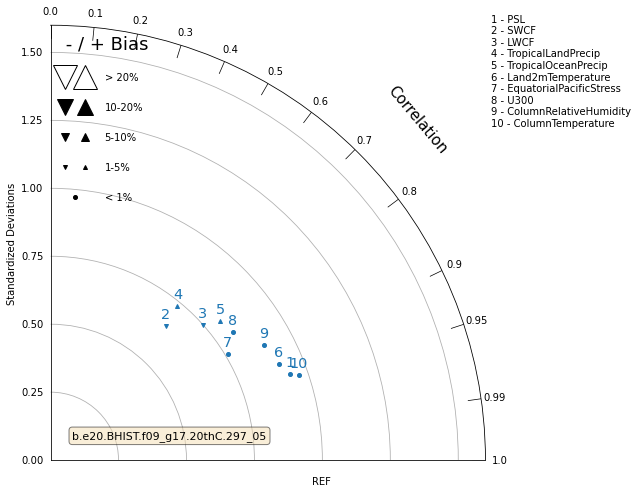

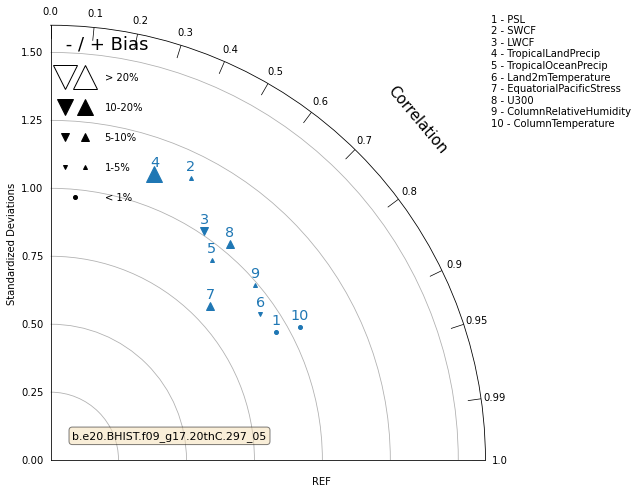

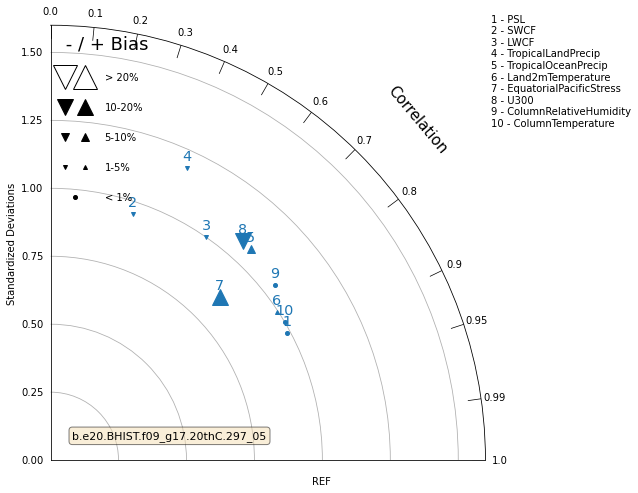

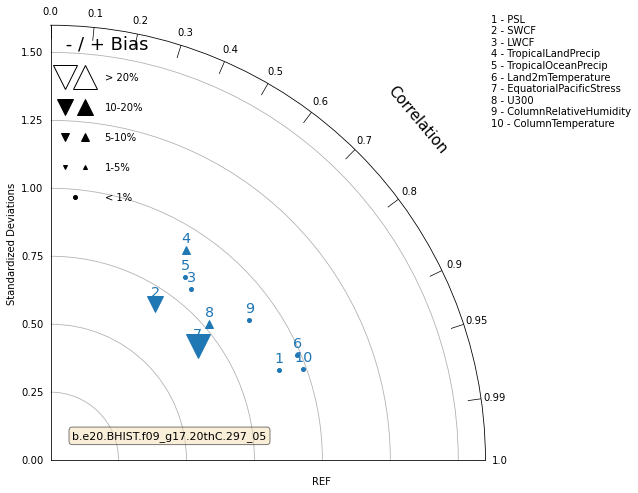

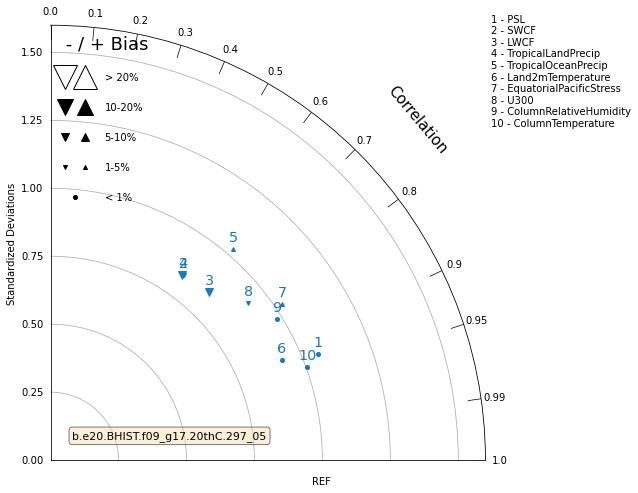

In [55]:
cam_taylor_diagram(adf)

In [13]:
adf.get_baseline_info('cam_climo_loc')

'/glade/scratch/brianpm/cam_diag_climo/files/b.e20.BHIST.f09_g16.20thC.125.02'

In [46]:
df_template

NameError: name 'df_template' is not defined

Text(0.9, 0.9, '1 - PSL\n2 - SWCF\n3 - LWCF\n4 - TropicalLandPrecip\n5 - TropicalOceanPrecip\n6 - Land2mTemperature\n7 - EquatorialPacificStress\n8 - U300\n9 - ColumnRelativeHumidity\n10 - ColumnTemperature')

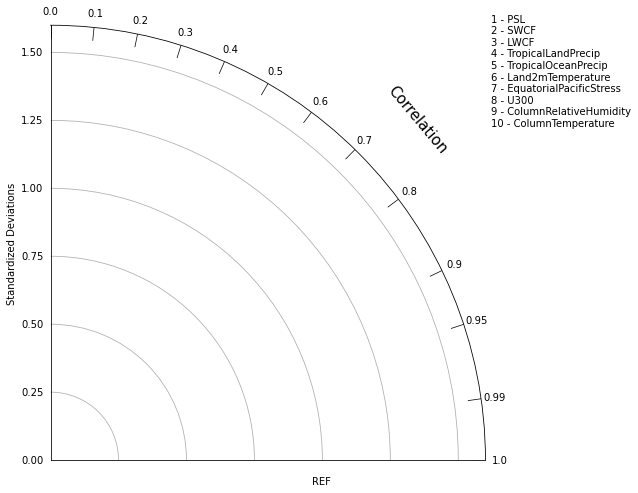

In [53]:
fgt, axt = taylor_plot_setup()
var_list = ['PSL', 'SWCF', 'LWCF', 
                'TropicalLandPrecip', 'TropicalOceanPrecip', 
                'Land2mTemperature', 'EquatorialPacificStress', 
                'U300', 'ColumnRelativeHumidity', 'ColumnTemperature']
txtstrs = [f"{i+1} - {v}" for i, v in enumerate(var_list)]
fgt.text(0.9, 0.9, "\n".join(txtstrs), va='top')

In [50]:
var_list

NameError: name 'var_list' is not defined